# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [ ]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
# !tar -xvf VOCtrainval_11-May-2012.tar

In [ ]:
# !pip install scipy==1.1.0

In [4]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [5]:
# Imports

import os
from os.path import join as pjoin
import collections
import json
import torch
import imageio
import numpy as np
import scipy.misc as m
import scipy.io as io
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import glob
import torch.nn as nn
import torchvision

from PIL import Image
from tqdm import tqdm
from torch.utils import data
from torchvision import transforms
import torch.nn as nn

### 1.1 Loading the dataset

In [6]:
# They took this loader from here: 
# https://github.com/meetshah1995/pytorch-semseg/tree/801fb200547caa5b0d91b8dde56b837da029f746/ptsemseg/loader

class pascalVOCDataset(data.Dataset):
    """Data loader for the Pascal VOC semantic segmentation dataset.

    Annotations from both the original VOC data (which consist of RGB images
    in which colours map to specific classes) and the SBD (Berkely) dataset
    (where annotations are stored as .mat files) are converted into a common
    `label_mask` format.  Under this format, each mask is an (M,N) array of
    integer values from 0 to 21, where 0 represents the background class.

    The label masks are stored in a new folder, called `pre_encoded`, which
    is added as a subdirectory of the `SegmentationClass` folder in the
    original Pascal VOC data layout.

    A total of five data splits are provided for working with the VOC data:
        train: The original VOC 2012 training data - 1464 images
        val: The original VOC 2012 validation data - 1449 images
        trainval: The combination of `train` and `val` - 2913 images
        train_aug: The unique images present in both the train split and
                   training images from SBD: - 8829 images (the unique members
                   of the result of combining lists of length 1464 and 8498)
        train_aug_val: The original VOC 2012 validation data minus the images
                   present in `train_aug` (This is done with the same logic as
                   the validation set used in FCN PAMI paper, but with VOC 2012
                   rather than VOC 2011) - 904 images
    """

    def __init__(
        self,
        root,
        sbd_path=None,
        split="train_aug",
        is_transform=False,
        img_size=512,
        augmentations=None,
        img_norm=True,
        test_mode=False,
    ):
        self.root = root
        self.sbd_path = sbd_path
        self.split = split
        self.is_transform = is_transform
        self.augmentations = augmentations
        self.img_norm = img_norm
        self.test_mode = test_mode
        self.n_classes = 21
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        self.files = collections.defaultdict(list)
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)

        if not self.test_mode:
            for split in ["train", "val", "trainval"]:
                path = pjoin(self.root, "ImageSets/Segmentation", split + ".txt")
                file_list = tuple(open(path, "r"))
                file_list = [id_.rstrip() for id_ in file_list]
                self.files[split] = file_list
            self.setup_annotations()

        self.tf = transforms.Compose(
            [
                # add more trasnformations as you see fit
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        im_name = self.files[self.split][index]
        im_path = pjoin(self.root, "JPEGImages", im_name + ".jpg")
        lbl_path = pjoin(self.root, "SegmentationClass/pre_encoded", im_name + ".png")
        im = Image.open(im_path)
        lbl = Image.open(lbl_path)
        if self.augmentations is not None:
            im, lbl = self.augmentations(im, lbl)
        if self.is_transform:
            im, lbl = self.transform(im, lbl)
        return im, torch.clamp(lbl, max=20)

    def transform(self, img, lbl):
        if self.img_size == ("same", "same"):
            pass
        else:
            img = img.resize((self.img_size[0], self.img_size[1]))  # uint8 with RGB mode
            lbl = lbl.resize((self.img_size[0], self.img_size[1]))
        img = self.tf(img)
        lbl = torch.from_numpy(np.array(lbl)).long()
        lbl[lbl == 255] = 0
        return img, lbl

    def get_pascal_labels(self):
        """Load the mapping that associates pascal classes with label colors

        Returns:
            np.ndarray with dimensions (21, 3)
        """
        return np.asarray(
            [
                [0, 0, 0],
                [128, 0, 0],
                [0, 128, 0],
                [128, 128, 0],
                [0, 0, 128],
                [128, 0, 128],
                [0, 128, 128],
                [128, 128, 128],
                [64, 0, 0],
                [192, 0, 0],
                [64, 128, 0],
                [192, 128, 0],
                [64, 0, 128],
                [192, 0, 128],
                [64, 128, 128],
                [192, 128, 128],
                [0, 64, 0],
                [128, 64, 0],
                [0, 192, 0],
                [128, 192, 0],
                [0, 64, 128],
            ]
        )

    def encode_segmap(self, mask):
        """Encode segmentation label images as pascal classes

        Args:
            mask (np.ndarray): raw segmentation label image of dimension
              (M, N, 3), in which the Pascal classes are encoded as colours.

        Returns:
            (np.ndarray): class map with dimensions (M,N), where the value at
            a given location is the integer denoting the class index.
        """
        mask = mask.astype(int)
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
        for ii, label in enumerate(self.get_pascal_labels()):
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
        label_mask = label_mask.astype(int)
        # print(np.unique(label_mask))
        return label_mask

    def decode_segmap(self, label_mask, plot=False):
        """Decode segmentation class labels into a color image

        Args:
            label_mask (np.ndarray): an (M,N) array of integer values denoting
              the class label at each spatial location.
            plot (bool, optional): whether to show the resulting color image
              in a figure.

        Returns:
            (np.ndarray, optional): the resulting decoded color image.
        """
        label_colours = self.get_pascal_labels()
        r = label_mask.copy()
        g = label_mask.copy()
        b = label_mask.copy()
        for ll in range(0, self.n_classes):
            r[label_mask == ll] = label_colours[ll, 0]
            g[label_mask == ll] = label_colours[ll, 1]
            b[label_mask == ll] = label_colours[ll, 2]
        rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        if plot:
            plt.imshow(rgb)
            plt.show()
        else:
            return rgb

    def setup_annotations(self):
        """Sets up Berkley annotations by adding image indices to the
        `train_aug` split and pre-encode all segmentation labels into the
        common label_mask format (if this has not already been done). This
        function also defines the `train_aug` and `train_aug_val` data splits
        according to the description in the class docstring
        """
        sbd_path = self.sbd_path
        target_path = pjoin(self.root, "SegmentationClass/pre_encoded")
        if not os.path.exists(target_path):
            os.makedirs(target_path)
        train_aug = self.files["train"]

        # keep unique elements (stable)
        train_aug = [train_aug[i] for i in sorted(np.unique(train_aug, return_index=True)[1])]
        self.files["train_aug"] = train_aug
        set_diff = set(self.files["val"]) - set(train_aug)  # remove overlap
        self.files["train_aug_val"] = list(set_diff)

        pre_encoded = glob.glob(pjoin(target_path, "*.png"))
        expected = np.unique(self.files["train_aug"] + self.files["val"]).size

        if len(pre_encoded) != expected:
            print("Pre-encoding segmentation masks...")

            for ii in tqdm(self.files["trainval"]):
                fname = ii + ".png"
                lbl_path = pjoin(self.root, "SegmentationClass", fname)
                lbl = self.encode_segmap(m.imread(lbl_path))
                lbl = m.toimage(lbl, high=lbl.max(), low=lbl.min())
                m.imsave(pjoin(target_path, fname), lbl)

        assert expected == 2913, "unexpected dataset sizes"

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

**We have implemented the U-Net architecture as introduced in the paper: https://arxiv.org/abs/1505.04597 with some additions**

In [7]:
## UNet Architecture With valid convolutions and batch norm in the double convolution block.
# Valid conv. added to keep the output size same as the input image.
# Batch norm was introduced after the U-Net paper was published, so it'll only benefit in learning.

# Defining the block consisting of double convolution operations (each unpadded 3x3 convolution  followed by a relu activation)
# as used in U-Net paper.   
# in_c : number of input channels and out_c : number of output channels
def double_conv(in_c, out_c):
    conv = nn.Sequential(
    nn.Conv2d(in_c, out_c, kernel_size = 3, stride = 1, padding = 1, bias = False),
    nn.BatchNorm2d(out_c),
    nn.ReLU(inplace=True),
    nn.Conv2d(out_c, out_c, kernel_size = 3, stride = 1, padding = 1, bias = False),
    nn.BatchNorm2d(out_c),
    nn.ReLU(inplace=True),
    )
    return conv
    
# Cropping the feature map from the contracting path to concatentate it with corresponding
# feature map in the expansive path.
def crop_img(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Defining 2x2 max pooling layer with stride 2 for downsampling in contractive path
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size = 2, stride = 2) 
        
        # 5 double convolution blocks with different number of filters/feature_channels
        self.down_conv_1 = double_conv(3,64)
        self.down_conv_2 = double_conv(64,128)
        self.down_conv_3 = double_conv(128,256)
        self.down_conv_4 = double_conv(256,512)
        self.down_conv_5 = double_conv(512,1024)
        
        # Up convolutions (2x2 up-convolutions) for the expansive path for upsampling
        self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2)
        # Double convolutions in the expansive path
        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2)        
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)        
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)        
        self.up_conv_4 = double_conv(128, 64)
        
        # 1x1 convolution, out_channels = total desired classes (21 including bgnd for pascal voc)
        self.out = nn.Conv2d(in_channels=64, out_channels = 21, kernel_size = 1)

    def forward(self, image):
        # encoder
        # image--> batch_size, #imagechannels, height, width

        # First double conv block
        #print(f'Original Image Size: {image.size()}')
        x1 = self.down_conv_1(image) # this map goes for concatenation
        #print(f'Feature Map Size After 1st Double Conv: {x1.size()}')
        # First max pooling oper. taking the o/p of 1st double conv block 
        x2 = self.max_pool_2x2(x1) 
        x3 = self.down_conv_2(x2) # this map goes for concatenation
        x4 = self.max_pool_2x2(x3) 
        x5 = self.down_conv_3(x4) # this map goes for concatenation
        x6 = self.max_pool_2x2(x5) 
        x7 = self.down_conv_4(x6) # this map goes for concatenation
        x8 = self.max_pool_2x2(x7) 
        x9 = self.down_conv_5 (x8)
        #print(f'Feature Map Size at the End of Contractive Path: {x9.size()}')
        
        # decoder
        x = self.up_trans_1(x9)
        # Cropping x7 to same size of x (feature map after up-sampling) for concatenation of both feature maps
        # Applying double convolution on the concatenated feature map
        x = self.up_conv_1(torch.cat([x,x7],1))
        
        x = self.up_trans_2(x)
        x = self.up_conv_2(torch.cat([x,x5],1))

        x = self.up_trans_3(x)
        x = self.up_conv_3(torch.cat([x,x3],1))
        
        x = self.up_trans_4(x)
        x = self.up_conv_4(torch.cat([x,x1],1))
        
        x = self.out(x)

        #print(f'Output Image Size: {x.size()}')
        return x

In [8]:
# Creating an instance of the model defined above. 
# You can modify it incase you need to pass paratemers to the constructor.
# model = UNet()
# model = UNet(num_classes=21)

In [9]:
# !pip install ipywidgets
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch
# Using https://github.com/qubvel/segmentation_models.pytorch library for testing purposes
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="efficientnet-b3",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=21,                      # model output channels (number of classes in your dataset)
)

### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [10]:
# local_path = './VOCtrainval_11-May-2012/VOCdevkit/VOC2012/' # modify it according to your device
raid_dir = '../../../../arja_raid'
local_path = raid_dir + '/datasets/VOCdevkit/VOC2012/' # modify it according to your device
bs = 4
epochs = 40

### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [11]:
# dataset variable
# augs = aug.Compose([aug.RandomRotate(10), aug.RandomHorizontallyFlip()])
# Can add these augmentations like here 
# [https://github.com/meetshah1995/pytorch-semseg/blob/801fb200547caa5b0d91b8dde56b837da029f746/ptsemseg/loader/pascal_voc_loader.py#L18]

traindataset = pascalVOCDataset(root=local_path, is_transform=True, split='train')
validdataset = pascalVOCDataset(root=local_path, is_transform=True, split='val')
# dataloader variable
trainloader = data.DataLoader(traindataset, batch_size=bs, shuffle=True)
validloader = data.DataLoader(validdataset, batch_size=bs, shuffle=False)

print(f'Number of training images: {len(traindataset)}')
print(f'Number of validation images: {len(validdataset)}')

Number of training images: 1464
Number of validation images: 1449


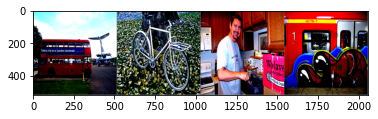

In [12]:
## Just added this cell for visualization of 3 images

def imshow(inp, title=None):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.5, 0.5, 0.5])
  std = np.array([0.5, 0.5, 0.5])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
      plt.title(title)

it = iter(trainloader)
images, labels = next(it)
out = torchvision.utils.make_grid(images)
imshow(out)
plt.show()

In [ ]:
# i, d in enumerate(trainloader) ---> here, d is list
# img--d[0] has the shape [2,3,512,512] or [batch_sz, #img_channels, img_sz, img_sz] -- img batch
# label--d[1] has the shape [2, 512, 512] or [batch_sz, mask_sz, mask_sz] -- mask batch
# Verifying training and validation data
def visualize_data(batch_sz, loader, dataset_var, data_title):
    dst = dataset_var
    for i, data in enumerate(loader):
        # increase the count if u want to visualize more batches
        if i>0:
            break
        imgs, labels = data
        imgs = imgs.numpy()
        imgs = np.transpose(imgs, [0,2,3,1])

        fig, axes = plt.subplots(nrows = 2, ncols = batch_sz, figsize=(15,5))
        fig.suptitle(data_title, fontsize=20)
        for j in range(0, batch_sz):
            I = imgs[j]
            axes[0,j].imshow(np.clip(I, 0, 1))
            axes[1,j].imshow(dst.decode_segmap(labels.numpy()[j]))
        plt.title('hi')
        plt.show()

visualize_data(bs, trainloader, traindataset, 'training data')
visualize_data(bs, validloader, validdataset, 'validation data')

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [13]:
# loss function
loss_f = nn.CrossEntropyLoss()

# optimizer variable
# opt = torch.optim.SGD(model.parameters(), weight_decay=5*1e-4, lr = 0.0001, momentum=0.9)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [14]:
def save_checkpoint(state, filename):
    #print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint_path, model):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["state_dict"])

In [15]:
def evaluate(dataset, data_loader, model, epoch):

    # put model in eval mode
    model.eval()
    # init final_loss to 0
    final_loss = 0
    # calculate number of batches and init tqdm
    num_batches = int(len(dataset) / data_loader.batch_size)
    tk0 = tqdm(data_loader, total=num_batches)
    # we need no_grad context of torch. this save memory
    with torch.no_grad():
        for inputs, targets in tk0:
            tk0.set_description(f"Validation Epoch {epoch+1}")
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.long)
            output = model(inputs)
            loss = criterion(output, targets)
            # add loss to final loss
            final_loss += loss
            tk0.set_postfix(loss = (final_loss / num_batches).item())
    # close tqdm
    tk0.close()
    # return average loss over all batches
    return final_loss / num_batches

In [17]:
# Implementation from Abhishek Thakur book - pg 216
# Can also look at this training loop implementation:
# https://github.com/Dhr11/Semantic_Segmentation/blob/master/Main_src.py]

def train(traindataset, validdataset, trainloader, validloader, model, criterion, optimizer, epochs, Load_Model=False):
    """
    training function that trains for one epoch
    :param dataset: dataset class
    :param data_loader: torch dataset loader
    :param model: model
    :param criterion: loss function
    :param optimizer: adam, sgd, etc.
    """

    if torch.cuda.is_available():
        criterion = criterion.cuda()

    # calculate number of batches
    num_batches = int(len(traindataset)/trainloader.batch_size)
    
    train_loss = []
    valid_loss = []
    model_weights = []
    valid_loss_min = np.Inf
    
    if Load_Model:
        load_checkpoint("my_checkpoint.pth.tar", model)

    # if we have more than one GPU, we can use both of them! [It needs some changes in model loading as well - try later]
#     if torch.cuda.device_count() > 1:
#         print(f"Let's use {torch.cuda.device_count()} GPUs!")
#         model = nn.DataParallel(model)
    

    for epoch in range (epochs):
        # putting the model in train mode
        model.train()

        with tqdm(trainloader, unit="batch") as tk0:
            for inputs, targets in tk0:
                tk0.set_description(f"Training Epoch {epoch+1}")
                # fetch input images and masks from dataset batch
                # move images and masks to cpu/gpu device
                inputs = inputs.to(device, dtype=torch.float)
                targets = targets.to(device, dtype=torch.long)
                # zero grad the optimizer
                optimizer.zero_grad()

                # forward step of model
                outputs = model(inputs)

                # calculate loss
                loss = criterion(outputs, targets)

                loss.backward()
                # step the optimizer
                optimizer.step()
                tk0.set_postfix(loss=loss.item())
                        
        val_loss_log = evaluate(
            validdataset,
            validloader,
            model,
            epoch
        )
        
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        
#         if val_loss_log <= valid_loss_min:
#             print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min,val_loss_log))
#             # save checkpoint as best model
#             save_checkpoint(checkpoint)
#             valid_loss_min = val_loss_log
        
        save_checkpoint(checkpoint, filename = "m9_unetef3_40epoch_ep_" + str(epoch) + ".pth.tar")

        # We can probably remove these 2 lines (can just utilize save and load checkpoint functions)
        #model_weights.append(model.state_dict())
        #torch.save(model.state_dict(), "./task1_models")

        train_loss.append(loss.item())
        valid_loss.append(val_loss_log.item())
      
    return train_loss, model_weights, valid_loss

In [18]:
device = "cuda" 
model.to(device)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        

In [ ]:
criterion = loss_f
history = train(traindataset, validdataset, trainloader, validloader, model, criterion, opt, epochs)

In [ ]:
fig = plt.figure()
plt.plot(history[0])
plt.plot(history[2])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
fig.savefig('./Loss-Curves/m9_unetef3_40epoch.png')

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [55]:
# Source: https://github.com/kevinzakka/pytorch-goodies/blob/master/metrics.py
from sklearn import metrics
from tqdm import tqdm

EPS = 1e-10


def nanmean(x):
    """Computes the arithmetic mean ignoring any NaNs."""
    return torch.mean(x[x == x])


def _fast_hist(true, pred, num_classes):
    mask = (true >= 0) & (true < num_classes)
    hist = torch.bincount(
        num_classes * true[mask] + pred[mask],
        minlength=num_classes ** 2,
    ).reshape(num_classes, num_classes).float()
    return hist


def jaccard_index(hist):
    """Computes the Jaccard index, a.k.a the Intersection over Union (IoU).
    Args:
        hist: confusion matrix.
    Returns:
        avg_jacc: the average per-class jaccard index.
    """
    A_inter_B = torch.diag(hist)
    A = hist.sum(dim=1)
    B = hist.sum(dim=0)
    jaccard = A_inter_B / (A + B - A_inter_B + EPS)
    avg_jacc = nanmean(jaccard)
    return avg_jacc


def dice_coefficient(hist):
    """Computes the Sørensen–Dice coefficient, a.k.a the F1 score.
    Args:
        hist: confusion matrix.
    Returns:
        avg_dice: the average per-class dice coefficient.
    """
    A_inter_B = torch.diag(hist)
    A = hist.sum(dim=1)
    B = hist.sum(dim=0)
    dice = (2 * A_inter_B) / (A + B + EPS)
    avg_dice = nanmean(dice)
    return avg_dice

# def roc_auc_score_multi_class(actual_class, pred_class, average = "macro"):

#     #creating a set of all the unique classes using the actual class list
#     unique_class = set(actual_class)
#     roc_auc_img = 0
#     for per_class in unique_class:
#         #creating a list of all the classes except the current class 
#         other_class = [x for x in unique_class if x != per_class]

#         #marking the current class as 1 and all other classes as 0
#         new_actual_class = [0 if x in other_class else 1 for x in actual_class]
#         new_pred_class = [0 if x in other_class else 1 for x in pred_class]

#         #using the sklearn metrics method to calculate the roc_auc_score
#         roc_auc = metrics.roc_auc_score(new_actual_class, new_pred_class, average = average)
#         roc_auc_img += roc_auc

#     return roc_auc_img/len(unique_class)

def roc_auc_score_multi_class(actual_class, pred_class, average = "macro"):
    start_time = time.time()
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_img = 0
    
    new_actual_class = np.zeros(len(actual_class))
    new_pred_class = np.zeros(len(pred_class))
    
    for per_class in unique_class:
        
        new_actual_class[actual_class == per_class] = 1
        new_pred_class[pred_class == per_class] = 1

        try:
            roc_auc = metrics.roc_auc_score(new_actual_class, new_pred_class, average = average)
        except ValueError:
            pass
        
        roc_auc_img += roc_auc

    return roc_auc_img/len(unique_class)


def eval_metrics(true, pred, num_classes, batch_sz):
    """Computes various segmentation metrics on 2D feature maps.
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        pred: a tensor of shape [B, H, W] or [B, 1, H, W].
        num_classes: the number of classes to segment. This number
            should be less than the ID of the ignored class.
    Returns:
        overall_acc: the overall pixel accuracy.
        avg_per_class_acc: the average per-class pixel accuracy.
        avg_jacc: the jaccard index.
        avg_dice: the dice coefficient.
    """
    hist = torch.zeros((num_classes, num_classes))
    f1_score = 0
    auc_score = 0
    # true--> 2d batch labels (8,512,512) and 2d batch pred---> (8,512,512) 
    for t, p in zip(true, pred):
        # flattening 1 label channel or 1 mask at a time
        hist += _fast_hist(t.flatten(), p.flatten(), num_classes)
        f1_score += metrics.f1_score(t.flatten().numpy(), p.flatten().numpy(), average='micro')
        auc_score += roc_auc_score_multi_class(t.flatten().numpy(), p.flatten().numpy())
    avg_jacc = jaccard_index(hist)
    avg_dice = dice_coefficient(hist)
    return avg_jacc, avg_dice, f1_score/batch_sz, auc_score/batch_sz

In [56]:
load_checkpoint(raid_dir + "/trained_models/Task1/m9_unetef3_40epoch/m9_unetef3_40epoch_ep_" + str(38) + ".pth.tar", model)
model.eval()

avg_jacc_final = 0
avg_dice_final = 0
f1_score_final = 0
auc_score_final = 0

num_batches = int(len(traindataset)/bs) # len(traindataset) is the total train images and bs is the batch_size 

with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(trainloader)):
        images, labels = images.to(device), labels.to(device)            

        output = torch.sigmoid(model(images))
        output_2d = torch.argmax(output, dim=1).detach().cpu()
        labels = labels.cpu()
        avg_jacc, avg_dice, f1_score, auc_score = eval_metrics(labels, output_2d, num_classes=21, batch_sz=bs)
        avg_jacc_final += avg_jacc.numpy()
        avg_dice_final += avg_dice.numpy()
        f1_score_final += f1_score
        auc_score_final += auc_score
        
print(f'avg_jacc or iou: {avg_jacc_final/num_batches}, avg_dice: {avg_dice_final/num_batches},\
f1_score: {f1_score_final/num_batches}, AUC_Score: {auc_score_final/num_batches}')


=> Loading checkpoint


100%|██████████| 366/366 [19:30<00:00,  3.20s/it]

avg_jacc or iou: 0.2309633574036301, avg_dice: 0.2480328189300709,f1_score: 0.9704405570942196, AUC_Score: 0.8736662352981789


### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

In [ ]:
def eval_metric_per_epoch(model_dir, model, dataset, loader, bs):

    load_checkpoint(model_dir, model)
    model.eval()

    avg_jacc_final = 0
    avg_dice_final = 0
    f1_score_final = 0

    num_batches = int(len(dataset)/bs) # len(traindataset) is the total train images and bs is the batch_size 

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(loader)):
            images, labels = images.to(device), labels.to(device)            

            output = torch.sigmoid(model(images))
            output_2d = torch.argmax(output, dim=1).detach().cpu()
            labels = labels.cpu()
            avg_jacc, avg_dice, f1_score = eval_metrics(labels, output_2d, num_classes=21, batch_sz=bs)
            avg_jacc_final += avg_jacc.numpy()
            avg_dice_final += avg_dice.numpy()
            f1_score_final += f1_score

    
    print(f'avg_jacc or iou: {avg_jacc_final/num_batches}, avg_dice: {avg_dice_final/num_batches}, f1_score: {f1_score_final/num_batches}')
    
    return avg_jacc_final/num_batches, avg_dice_final/num_batches, f1_score_final/num_batches

In [ ]:
f1_scores = []
iou_scores = []
dice_scores = []

loader = trainloader
dataset = traindataset
bs = bs

for epoch in range(0, epochs):
    model_dir = "./trained_models/m9_unetef3_40epoch/m9_unetef3_40epoch_ep_" + str(epoch) + ".pth.tar"
    iou, dice, f1 = eval_metric_per_epoch(model_dir, model, dataset, loader, bs)
    iou_scores.append(iou)
    dice_scores.append(dice)
    f1_scores.append(f1)

plt.plot(iou_scores)
plt.plot(dice_scores)
plt.plot(f1_scores)
plt.legend(['iou','dice','f1-score'])
plt.show()  

In [ ]:
plt.plot(dice_scores)
plt.legend(['Dice Score'])
plt.savefig('m9_unetef3_40epoch_dicescore.png')

In [ ]:
# f1_scores = []
# auc_scores = []
# dice_scores = []

# checkpoint = torch.load("smpUnet_my_checkpoint_5epch.pth.tar")
# model = checkpoint['model'] # not working but need to find a way to make it work for faster compute

# # Or can just add these metrics f1, auc, and dice in the training and just plot the logs here.

# for epoch in range(0, epochs):
#     model.load_state_dict(history[1][epoch])
#     for parameter in model.parameters():
#         parameter.requires_grad = False
#     model.eval()
    
# #     load_checkpoint(torch.load("smpUnet_my_checkpoint_5epch.pth.tar"), model)
#     for images,labels in trainloader:
#         print(images.size(), labels.size())
#         images, labels = images.to(device), labels.to(device) 
#         output = model(images)
#         auc, dice = evaluate(labels.cuda(), output)
#         fl_scores.append(f1)
#         auc_scores.append(auc)
#         dice_scores.append(dice)
        
# plt.plot(f1_scores)
# plt.plot(auc_scores)
# plt.plot(dice_scores)
# plt.legend(['auc', 'dice'])
# plt.show()        

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

**Visualization using out torch.argmax Function for Prediction Processing**

In [ ]:
from skimage.io import imsave
load_checkpoint(raid_dir + "/trained_models/Task1/m1_dplabv3_30epoch_ep_" + str(27) + ".pth.tar", model)

model.eval()

for batch_idx, (images,labels) in enumerate(trainloader):
    # Number of batches to analyze
    if batch_idx>4:
        break
    #output = model(images.cuda())
    images, labels = images.to(device), labels.to(device)
    
    output = torch.sigmoid(model(images))
    output_2d = torch.argmax(output, dim=1).detach().cpu().numpy()
    
    imgs = images.cpu().numpy().transpose([0,2,3,1])
    
    save_path = './saved_results_task1/m1_dplabv3_30epoch/'
    
    # Analyzing every image in the batch
    for img_num in range(0,bs): 
        plt.figure(figsize=(15,20))
        
        plt.subplot(1,3,1).set_title('Original_Image')
        plt.imshow(np.clip(imgs[img_num,:,:,:], 0, 1))
        imsave(save_path + 'org_img_' + str(img_num) + '.png', np.uint8(np.clip(imgs[img_num,:,:,:], 0, 1)*255))
        
        plt.subplot(1,3,2).set_title('Ground Truth')
        GT_mask_rgb = traindataset.decode_segmap(labels.cpu().numpy()[img_num])
        plt.imshow(GT_mask_rgb) # Single channel GT mask to RGB Image
        imsave(save_path + 'gt_mask_' + str(img_num) + '.png', GT_mask_rgb)
        
        plt.subplot(1,3,3).set_title('Prediction_UNet')
        pred_mask_rgb = traindataset.decode_segmap(output_2d[img_num])
        plt.imshow(pred_mask_rgb) # Single channel prediction mask to RGB Image
        imsave(save_path + 'pred_mask_' + str(img_num) + '.png', pred_mask_rgb)
        
        plt.savefig(save_path + 'all_res_batch_' + str(batch_idx) + '_img_' + str(img_num) + '.png')

**Helpful resources for part 2**

Cityscapes data loader similar to pascal voc: https://github.com/meetshah1995/pytorch-semseg/tree/801fb200547caa5b0d91b8dde56b837da029f746/ptsemseg/loader/

### References:
https://learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/ <br/>
https://github.com/mateuszbuda/brain-segmentation-pytorch/blob/master/unet.py <br/>
https://github.com/meetshah1995/pytorch-semseg/blob/801fb200547caa5b0d91b8dde56b837da029f746/ptsemseg/models/segnet.py <br/>
https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705 <br/>
https://www.kaggle.com/dhananjay3/image-segmentation-from-scratch-in-pytorch <br/>
https://towardsdatascience.com/everything-you-need-to-know-about-saving-weights-in-pytorch-572651f3f8de